In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from influxdb_client.client.warnings import MissingPivotFunction
from influxdb_client import InfluxDBClient
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime, timedelta

In [2]:
host = "http://kammeyer.uk:8086"
token = "9V1NYZbTXZkbf9H0Szf8Gl-dOaqrl97TmdC9gwNhxkRCgAcHR7jGSxnPtwHq2vBL-UOd607yPlROxlJAhRAwqw=="
org = "messme"

client = InfluxDBClient(url=host, token=token, org=org)

bucket = "price"


# Fetch data for the last 180 days
query = f'from(bucket: "{bucket}") |> range(start: -732d) |> filter(fn: (r) => r["_measurement"] == "price")'

warnings.simplefilter("ignore", MissingPivotFunction)

query_api = client.query_api()
data = query_api.query_data_frame(query)

result=data.copy()
#drop unnecessary columns
result = result.drop(['result', 'table', '_start', '_stop', '_field', '_measurement','region'], axis=1) 
result['_time'] = pd.to_datetime(result['_time'])
result['_time'] =result['_time'].dt.tz_localize(None)
# Set time as index
result.set_index('_time', inplace=True)
result['_value'] = pd.to_numeric(result['_value'], errors='coerce')

# Round down the timestamp to the nearest hour
result.index = result.index.floor('H')


# Group by the rounded-down timestamp and aggregate the data (e.g., take the mean)
result = result.groupby(result.index).mean()

# Assuming 'result' is the DataFrame with a datetime index
result.index = pd.to_datetime(result.index)


# Filter the data based on the desired end date
result.index = pd.to_datetime(result.index)
result

,_value
_time,
2022-02-02 01:00:00,10.05
2022-02-02 02:00:00,10.36
2022-02-02 03:00:00,20.03
2022-02-02 04:00:00,67.31
2022-02-02 05:00:00,105.03
...,...
2024-02-03 21:00:00,50.81
2024-02-03 22:00:00,38.71
2024-02-03 23:00:00,35.30


In [3]:
start_date = datetime(2023, 9, 28)
end_date = datetime(2024, 1, 28) 



result_clipped1 = result[(result.index >= start_date) & (result.index < end_date)]
result_clipped1

,_value
_time,
2023-09-28 00:00:00,72.95
2023-09-28 01:00:00,74.84
2023-09-28 02:00:00,80.87
2023-09-28 03:00:00,92.88
2023-09-28 04:00:00,115.35
...,...
2024-01-27 19:00:00,84.42
2024-01-27 20:00:00,76.07
2024-01-27 21:00:00,75.97


In [4]:
given_date_test = end_date

given_date_last_year = given_date_test.replace(year=given_date_test.year - 1)


six_weeks_before = given_date_last_year - timedelta(weeks=6)
six_weeks_after = given_date_last_year + timedelta(weeks=6)

result_clipped2 = result[(result.index >= six_weeks_before) & (result.index < six_weeks_after)]
result_clipped2

,_value
_time,
2022-12-17 00:00:00,271.08
2022-12-17 01:00:00,259.95
2022-12-17 02:00:00,246.13
2022-12-17 03:00:00,238.73
2022-12-17 04:00:00,237.36
...,...
2023-03-10 19:00:00,115.41
2023-03-10 20:00:00,108.96
2023-03-10 21:00:00,100.35


In [5]:
result_clipped = pd.concat([result_clipped2, result_clipped1])
result_clipped

,_value
_time,
2022-12-17 00:00:00,271.08
2022-12-17 01:00:00,259.95
2022-12-17 02:00:00,246.13
2022-12-17 03:00:00,238.73
2022-12-17 04:00:00,237.36
...,...
2024-01-27 19:00:00,84.42
2024-01-27 20:00:00,76.07
2024-01-27 21:00:00,75.97


In [6]:
result_clipped['hour'] = result_clipped.index.hour
result_clipped['Month'] = result_clipped.index.month
result_clipped['Day'] = result_clipped.index.day

result_clipped['Day_of_week'] = result_clipped.index.dayofweek + 1
result_clipped = result_clipped.fillna(0)
result_clipped

,_value,hour,Month,Day,Day_of_week
_time,,,,,
2022-12-17 00:00:00,271.08,0,12,17,6
2022-12-17 01:00:00,259.95,1,12,17,6
2022-12-17 02:00:00,246.13,2,12,17,6
2022-12-17 03:00:00,238.73,3,12,17,6
2022-12-17 04:00:00,237.36,4,12,17,6
...,...,...,...,...,...
2024-01-27 19:00:00,84.42,19,1,27,6
2024-01-27 20:00:00,76.07,20,1,27,6
2024-01-27 21:00:00,75.97,21,1,27,6


In [7]:
# Specify the number of hours for prediction
num_hours_for_prediction = 7 * 24

# test_start=datetime(2024, 1, 10) 

# Create a new DataFrame for the test data
test_data = pd.DataFrame(index=pd.date_range(start=result_clipped1.index[-1] + timedelta(hours=1), periods=num_hours_for_prediction, freq='H'))
# test_data = pd.DataFrame(index=pd.date_range(start=test_start + timedelta(hours=1), periods=num_hours_for_prediction, freq='H'))



# Extract features for the next 7 days
test_data['hour'] = test_data.index.hour
test_data['Month'] = test_data.index.month
test_data['Day'] = test_data.index.day


test_data['Day_of_week'] = test_data.index.dayofweek + 1

# Fill NaN values with 0 (if needed)
test_data = test_data.fillna(0)
test_data

,hour,Month,Day,Day_of_week
2024-01-28 00:00:00,0,1,28,7
2024-01-28 01:00:00,1,1,28,7
2024-01-28 02:00:00,2,1,28,7
2024-01-28 03:00:00,3,1,28,7
2024-01-28 04:00:00,4,1,28,7
...,...,...,...,...
2024-02-03 19:00:00,19,2,3,6
2024-02-03 20:00:00,20,2,3,6
2024-02-03 21:00:00,21,2,3,6
2024-02-03 22:00:00,22,2,3,6


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'result_clipped' is the training data DataFrame
# Assuming '_value' is the target variable to be predicted

# Features for training
X_train = result_clipped[['hour', 'Month', 'Day', 'Day_of_week']]
y_train = result_clipped['_value']

# Split training data into training and validation sets (optional)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


# Features for test
X_test = test_data[['hour', 'Month', 'Day', 'Day_of_week']]

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the validation set (optional)
if 'X_val' in locals():
    y_val_pred = rf_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f'Validation RMSE: {val_rmse}')
    r2 = r2_score(y_val, y_val_pred)
    print(f'Validation R2: {r2}')
    

# Predict on the test data
y_test_pred = rf_model.predict(X_test)

# Create a new DataFrame for test results
test_results = X_test.copy()

# Add the predicted values to the DataFrame
test_results['_value_pred'] = y_test_pred
# test_results['_value_pred'] -= 40
test_results

Validation RMSE: 15.326683262437376
Validation R2: 0.921312014228346


,hour,Month,Day,Day_of_week,_value_pred
2024-01-28 00:00:00,0,1,28,7,126.2861
2024-01-28 01:00:00,1,1,28,7,127.0556
2024-01-28 02:00:00,2,1,28,7,120.9477
2024-01-28 03:00:00,3,1,28,7,117.9578
2024-01-28 04:00:00,4,1,28,7,116.8112
...,...,...,...,...,...
2024-02-03 19:00:00,19,2,3,6,161.1473
2024-02-03 20:00:00,20,2,3,6,145.8739
2024-02-03 21:00:00,21,2,3,6,141.1561
2024-02-03 22:00:00,22,2,3,6,133.0100


In [9]:
test_results.to_csv('result3.1.csv', index=True)

In [10]:
# # Fetch actual values for the days/hours corresponding to predictions
# actual_values = result.loc[test_results.index, '_value']

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(actual_values.index, actual_values, label='Actual Values', marker='o')
# plt.plot(test_results.index, test_results['_value_pred'], label='Predicted Values', marker='o')
# plt.xlabel('Date and Time')
# plt.ylabel('Value')
# plt.title('Actual vs Predicted Values')
# plt.legend()
# plt.show()

In [11]:
# mae_rf = mean_absolute_error(actual_values, test_results['_value_pred'])
# rmse_rf = np.sqrt(mean_squared_error(actual_values, test_results['_value_pred']))
# print(f'MAE (Random Forest): {mae_rf:.2f}')
# print(f'RMSE (Random Forest): {rmse_rf:.2f}')


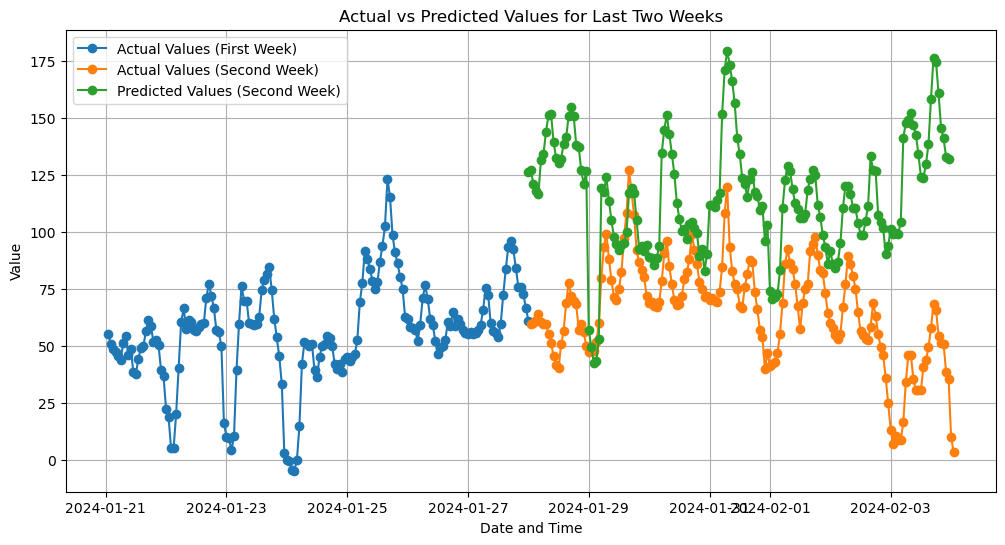

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


# Find the start timestamp for the last two weeks
last_timestamp = result.index[-1]
start_timestamp_last_two_weeks = last_timestamp - pd.Timedelta(weeks=2)

# Split the result DataFrame into two weeks
result_last_two_weeks = result.loc[result.index >= start_timestamp_last_two_weeks]

# Define the midpoint of the two-week period
midpoint_timestamp = start_timestamp_last_two_weeks + pd.Timedelta(weeks=1)

# Split the result DataFrame into two: first and second week
result_first_week = result_last_two_weeks.loc[result_last_two_weeks.index < midpoint_timestamp]
result_second_week = result_last_two_weeks.loc[result_last_two_weeks.index >= midpoint_timestamp]

# Plot actual values for the first week and actual vs predicted values for the second week
plt.figure(figsize=(12, 6))

# Plot actual values for the first week
plt.plot(result_first_week.index, result_first_week['_value'], label='Actual Values (First Week)', marker='o')

# Plot actual values for the second week
plt.plot(result_second_week.index, result_second_week['_value'], label='Actual Values (Second Week)', marker='o')

# Plot predicted values for the second week
plt.plot(test_results.index, test_results['_value_pred'], label='Predicted Values (Second Week)', marker='o')

plt.xlabel('Date and Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values for Last Two Weeks')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
#Introducing Rolling Statistics for test data

In [14]:
# Rolling Statistics
window_sizes = [24]  # Window sizes for rolling statistics
for window in window_sizes:
    result_clipped1[f'rolling_mean_{window}'] = result_clipped1['_value'].rolling(window=window).mean()
    result_clipped2[f'rolling_mean_{window}'] = result_clipped2['_value'].rolling(window=window).mean()


result_clipped1= result_clipped1.iloc[24:]
result_clipped2= result_clipped2.iloc[24:]


result_clipped_12_rolling_mean = pd.concat([result_clipped2, result_clipped1])
result_clipped_12_rolling_mean

,_value,rolling_mean_24
_time,,
2022-12-18 00:00:00,168.67,260.217500
2022-12-18 01:00:00,170.28,256.481250
2022-12-18 02:00:00,172.11,253.397083
2022-12-18 03:00:00,172.43,250.634583
2022-12-18 04:00:00,169.49,247.806667
...,...,...
2024-01-27 19:00:00,84.42,66.429583
2024-01-27 20:00:00,76.07,67.015000
2024-01-27 21:00:00,75.97,67.697917


In [15]:
result_clipped

,_value,hour,Month,Day,Day_of_week
_time,,,,,
2022-12-17 00:00:00,271.08,0,12,17,6
2022-12-17 01:00:00,259.95,1,12,17,6
2022-12-17 02:00:00,246.13,2,12,17,6
2022-12-17 03:00:00,238.73,3,12,17,6
2022-12-17 04:00:00,237.36,4,12,17,6
...,...,...,...,...,...
2024-01-27 19:00:00,84.42,19,1,27,6
2024-01-27 20:00:00,76.07,20,1,27,6
2024-01-27 21:00:00,75.97,21,1,27,6


In [16]:
merged_result_clipped = pd.merge(result_clipped, result_clipped_12_rolling_mean, left_index=True, right_index=True, how='inner')
merged_result_clipped

,_value_x,hour,Month,Day,Day_of_week,_value_y,rolling_mean_24
_time,,,,,,,
2022-12-18 00:00:00,168.67,0,12,18,7,168.67,260.217500
2022-12-18 01:00:00,170.28,1,12,18,7,170.28,256.481250
2022-12-18 02:00:00,172.11,2,12,18,7,172.11,253.397083
2022-12-18 03:00:00,172.43,3,12,18,7,172.43,250.634583
2022-12-18 04:00:00,169.49,4,12,18,7,169.49,247.806667
...,...,...,...,...,...,...,...
2024-01-27 19:00:00,84.42,19,1,27,6,84.42,66.429583
2024-01-27 20:00:00,76.07,20,1,27,6,76.07,67.015000
2024-01-27 21:00:00,75.97,21,1,27,6,75.97,67.697917


In [17]:
#24 hours rolling mean

# Filter the DataFrame for the last day
last_day_data = merged_result_clipped[merged_result_clipped.index.date == pd.to_datetime(result_clipped.index[-1]).date()]

# Calculate the average '_value' for the last day
average_last_day = last_day_data['_value_x'].mean()
average_last_day


68.81833333333334

In [18]:
# Create a new column 'rolling mean' and fill it with average_last_day for the first 24 entries
test_data['rolling_mean_24'] = 0  # Initialize the column with zeros
test_data.iloc[:24, test_data.columns.get_loc('rolling_mean_24')] = average_last_day
test_data

,hour,Month,Day,Day_of_week,rolling_mean_24
2024-01-28 00:00:00,0,1,28,7,68.818333
2024-01-28 01:00:00,1,1,28,7,68.818333
2024-01-28 02:00:00,2,1,28,7,68.818333
2024-01-28 03:00:00,3,1,28,7,68.818333
2024-01-28 04:00:00,4,1,28,7,68.818333
...,...,...,...,...,...
2024-02-03 19:00:00,19,2,3,6,0.000000
2024-02-03 20:00:00,20,2,3,6,0.000000
2024-02-03 21:00:00,21,2,3,6,0.000000
2024-02-03 22:00:00,22,2,3,6,0.000000


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming 'result_clipped' is the training data DataFrame
# Assuming '_value' is the target variable to be predicted

# Features for training
X_train = merged_result_clipped[['hour', 'Month', 'Day', 'Day_of_week','rolling_mean_24']]
y_train = merged_result_clipped['_value_x']

# Split training data into training and validation sets (optional)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the validation set (optional)
if 'X_val' in locals():
    y_val_pred = rf_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f'Validation RMSE: {val_rmse}')
    r2 = r2_score(y_val, y_val_pred)
    print(f'Validation R2: {r2}')


Validation RMSE: 16.610639816544687
Validation R2: 0.8980180327141689


In [20]:
unique_days = test_data.index.floor('D').unique()
unique_days

DatetimeIndex(['2024-01-28', '2024-01-29', '2024-01-30', '2024-01-31',
               '2024-02-01', '2024-02-02', '2024-02-03'],
              dtype='datetime64[ns]', freq=None)

In [21]:
# Create a new DataFrame for test results
y_test_pred_whole=[]

for day in unique_days:
    # Select data for the current day
    day_data = test_data[pd.to_datetime(test_data.index.date) == day]
    
    # Predict on the test data
    y_test_pred = rf_model.predict(day_data)
    
    
    predicted_rolling_mean = np.mean(y_test_pred)
    print(predicted_rolling_mean)
    
    next_day = day + pd.Timedelta(days=1)
    
    test_data.loc[test_data.index.date == next_day.date(), 'rolling_mean_24'] = predicted_rolling_mean
    
    y_test_pred_whole.extend(y_test_pred)

    
test_results = test_data.copy()
   
test_results['_value_pred'] = y_test_pred_whole  
# test_results['_value_pred'] -= 40
test_results  

59.226675
88.39822083333335
96.24398333333335
104.96727916666664
119.49143333333332
114.2173708333333
115.17215833333336


,hour,Month,Day,Day_of_week,rolling_mean_24,_value_pred
2024-01-28 00:00:00,0,1,28,7,68.818333,33.8652
2024-01-28 01:00:00,1,1,28,7,68.818333,34.1911
2024-01-28 02:00:00,2,1,28,7,68.818333,33.1470
2024-01-28 03:00:00,3,1,28,7,68.818333,32.3680
2024-01-28 04:00:00,4,1,28,7,68.818333,32.7068
...,...,...,...,...,...,...
2024-02-03 19:00:00,19,2,3,6,114.217371,136.7259
2024-02-03 20:00:00,20,2,3,6,114.217371,131.6826
2024-02-03 21:00:00,21,2,3,6,114.217371,121.8774
2024-02-03 22:00:00,22,2,3,6,114.217371,114.0428


In [22]:
test_results.to_csv('result3.2.csv', index=True)

In [23]:
# # Fetch actual values for the days/hours corresponding to predictions
# actual_values = result.loc[test_results.index, '_value']

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(actual_values.index, actual_values, label='Actual Values', marker='o')
# plt.plot(test_results.index, test_results['_value_pred'], label='Predicted Values', marker='o')
# plt.xlabel('Date and Time')
# plt.ylabel('Value')
# plt.title('Actual vs Predicted Values')
# plt.legend()
# plt.show()

In [24]:
# mae_rf = mean_absolute_error(actual_values, test_results['_value_pred'])
# rmse_rf = np.sqrt(mean_squared_error(actual_values, test_results['_value_pred']))
# print(f'MAE (Random Forest): {mae_rf:.2f}')
# print(f'RMSE (Random Forest): {rmse_rf:.2f}')


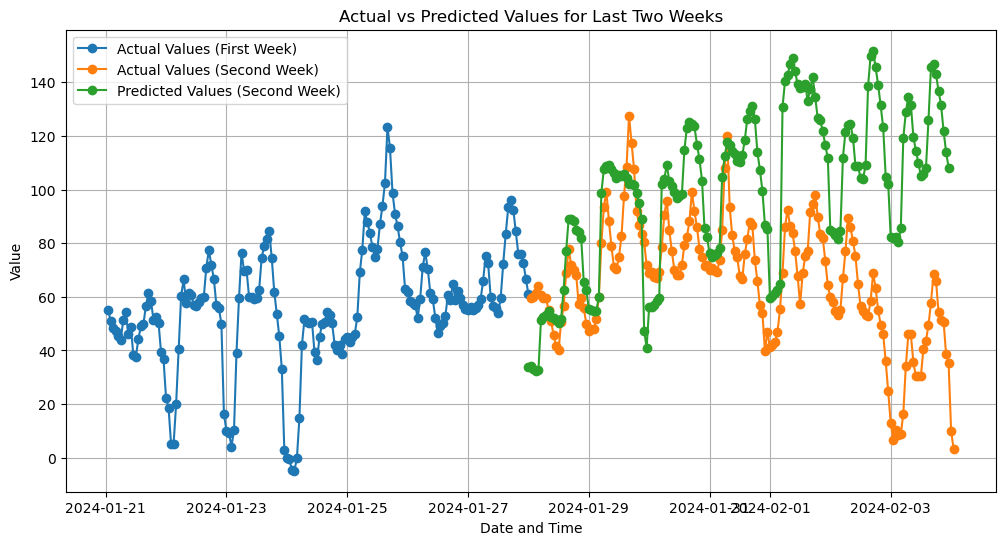

In [25]:
import pandas as pd
import matplotlib.pyplot as plt


# Find the start timestamp for the last two weeks
last_timestamp = result.index[-1]
start_timestamp_last_two_weeks = last_timestamp - pd.Timedelta(weeks=2)

# Split the result DataFrame into two weeks
result_last_two_weeks = result.loc[result.index >= start_timestamp_last_two_weeks]

# Define the midpoint of the two-week period
midpoint_timestamp = start_timestamp_last_two_weeks + pd.Timedelta(weeks=1)

# Split the result DataFrame into two: first and second week
result_first_week = result_last_two_weeks.loc[result_last_two_weeks.index < midpoint_timestamp]
result_second_week = result_last_two_weeks.loc[result_last_two_weeks.index >= midpoint_timestamp]

# Plot actual values for the first week and actual vs predicted values for the second week
plt.figure(figsize=(12, 6))

# Plot actual values for the first week
plt.plot(result_first_week.index, result_first_week['_value'], label='Actual Values (First Week)', marker='o')

# Plot actual values for the second week
plt.plot(result_second_week.index, result_second_week['_value'], label='Actual Values (Second Week)', marker='o')

# Plot predicted values for the second week
plt.plot(test_results.index, test_results['_value_pred'], label='Predicted Values (Second Week)', marker='o')

plt.xlabel('Date and Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values for Last Two Weeks')
plt.legend()
plt.grid(True)
plt.show()
